# Spotify Playlist Creation with K-Means algorithm

## Principal Component Analysis (PCA) with PowerTransformer Scaling
PCA is used to reduce noise and the dimensionality of the Spotify dataset before clustering the songs. This will help to identify the most important features of the songs, and it will also make the clustering process more efficient.
The PowerTransformer is used for scaling the features.

## Import of Libs and CSV file

In [489]:
import pandas as pd
import numpy as np
from sklearn.metrics import pairwise_distances, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PowerTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

songs_df = pd.read_csv('Spotify_data/3_spotify_5000_songs.csv')
songs_df.columns = songs_df.columns.str.strip()

songs_df.set_index('name', inplace=True)
songs_cat_df = songs_df.drop(['Unnamed: 0', 'artist', 'key', 'mode','type', 'duration_ms', 'time_signature', "id","html"], axis=1).copy()

## Scaling the data

In [260]:
# Create a PowerTransformer object
scaler = PowerTransformer().set_output(transform="pandas")

# Transform the songs_cat_df DataFrame
songs_cat_power = scaler.fit_transform(songs_cat_df)

## PCA

In [261]:
# Initialise the PCA object
pca = PCA()

# Fit the PCA object to the data
pca.fit(songs_cat_power)

# Transform songs_cat_power based on the fit calculations
pca_songs_df = pca.transform(songs_cat_power)

## Visualization of cumulative explained variance of principal components

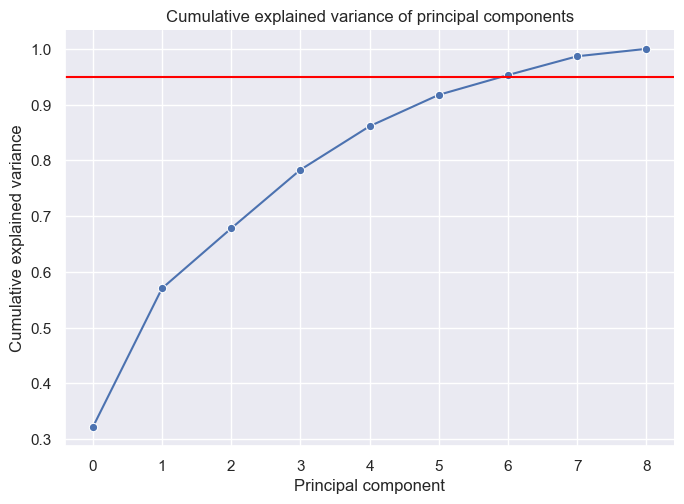

In [263]:
# Create a cumulative explained variance plot
explained_variance_array = pca.explained_variance_ratio_
(sns.relplot(
      kind = "line",  # Create a line plot
      x = range(len(explained_variance_array)),  # Set the x-axis to be the principal component index
      y = np.cumsum(explained_variance_array),  # Set the y-axis to be the cumulative explained variance
      marker = "o",  # Use a circle marker for the data points
      aspect = 1.4,  # Set the aspect ratio of the plot to be 1.4
  )
  # Set the title of the plot
  .set(title = "Cumulative explained variance of principal components")
  # Set the axis labels
  .set_axis_labels("Principal component", "Cumulative explained variance")
);

# Add a horizontal red line at 0.95 on the y axis
plt.axhline(y = 0.95,
            color = 'red');

## Select PCs with most significant impact (95% of cumulative explained variance)

In [264]:
# Initialise the PCA object
pca_variance = PCA(n_components = 0.95)

# Fit the PCA object to the data
pca_variance.fit(songs_cat_power)

# Transform scaled_features_df based on the fit calculations
pca_songs_df = pca_variance.transform(songs_cat_power)

array([[-1.13469221,  1.01821355,  2.01025967, ...,  1.18306295,
        -0.67479288,  0.15995066],
       [-0.58605111,  2.08474748, -0.01027625, ..., -0.19098476,
         0.2593253 , -0.48819753],
       [ 0.70562427,  1.70153979, -0.87826593, ...,  2.16566345,
         0.57751528, -0.35209732],
       ...,
       [-4.97253817, -1.12496847, -0.8863216 , ..., -0.01000299,
        -0.0149131 , -0.68708512],
       [-4.39610266, -0.81392174, -0.45110517, ..., -0.19082108,
        -0.19234049, -0.38879563],
       [-3.67063087,  0.01000944,  0.93981614, ..., -0.35763551,
         0.60669227, -0.13254265]])

## Find the best K-Value with KneeLocator


The selected random seed has a significant impact on the clustering of the K_Means algorithm. Therefore the average K-Value of 100 random seed values was selected as the best K-Value to move forward.

In [271]:
from kneed import KneeLocator
import random
# Decide on a random_state to use
seed_list = random.sample(range(1, 1001), 100)

# Set the maximum number of clusters to try
max_k = 100

# Create an empty lists to store knee locator values
kl_20_list = []

# Iterate over the range of seeds
for seed in seed_list:
    # Create an empty lists to store the inertia scores
    inertia_list = []
    # Iterate over the range of cluster numbers
    for i in range(1, max_k + 1):
    
        # Create a KMeans object with the specified number of clusters
        myKMeans = KMeans(n_clusters = i,
                          n_init = "auto",
                          random_state = seed)
    
        # Fit the KMeans model to the scaled data
        myKMeans.fit(pca_songs_df)
    
        # Append the inertia score to the list
        inertia_list.append(myKMeans.inertia_)
    
    inertia_list_20 = inertia_list[20:]
    k_range_20 = range(21, max_k + 1)
    # Use KneeLocator to find the elbow point
    kl_20_list.append(KneeLocator(k_range_20, inertia_list_20, curve='convex', direction='decreasing').elbow)

np.mean(kl_20_list)

47.83

## Use K-Means for the creation of playlists


In [272]:
# initialize the model
random_seed = 123
my_full_kmeans = KMeans(n_clusters = 48, n_init = "auto", random_state = seed)

# fit the model to the data
my_full_kmeans.fit(pca_songs_df)

# obtain the cluster output
category = my_full_kmeans.labels_

# attach the cluster output to our original DataFrame
songs_df["category"] = category

songs_per_playlist = songs_df['category'].value_counts()

## Visualization of songs per playlist
The requirement in this case study was to create playlists with a lenght of 50 to 250 songs. In this visualization you can see that with the selected scaling method, the amount of PCs and number of clusters, K_means is performing pretty well in creating playlists within the requested size. Only one playlist is outside of the requested playlist length.

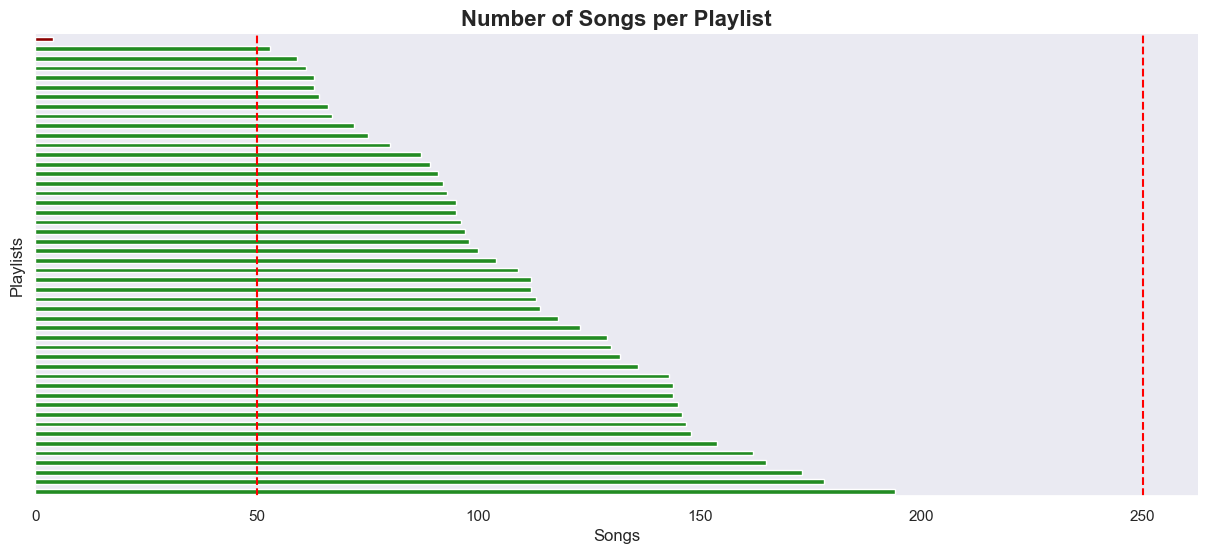

In [481]:
import matplotlib.pyplot as plt

# Plot
threshold = 50
colors = ['darkred' if value < threshold else 'forestgreen' for value in songs_per_playlist]
ax = songs_per_playlist.plot(kind='barh', figsize=(15, 6), color=colors)

# Hide y-axis tick labels (categories)
ax.set_yticklabels([])  # This hides the category labels
ax.tick_params(axis='y', which='both', length=0)  # Hide tick marks

# Keep axis label/title
ax.set_ylabel("Playlists")  # Your axis title
ax.set_xlabel("Songs")
ax.set_title("Number of Songs per Playlist", fontsize=16, fontweight='bold')
ax.grid(False)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

# add vertical lines for given range of songs per playlist:
plt.axvline(50, color="red", linestyle='--')
plt.axvline(250, color="red", linestyle='--')

# Optional: Adjust thickness of bars (increase height per bar)
# bar_count = len(songs_per_playlist)
# ax.figure.set_size_inches(12, bar_count * 0.6)  # Increase height per bar

# Optional: Save the chart as a PNG file at the specified path
# plt.savefig(r"PATH\Songs_per_Playlist", dpi=300, bbox_inches='tight')

plt.show()

## Selection of two example playlists


In [414]:
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_colwidth', None)
songs_title_cat_df = songs_df[['artist', 'category']]
test_pl_1 = songs_title_cat_df.loc[songs_title_cat_df['category'] == 3] # change the number of the category here and you can review what songs this particular playlist consists of
test_pl_1

,artist,category
name,,
Flames (with ZAYN) - R3HAB & Skytech VIP Remix,R3HAB,3
Hip-Hop,Dead Prez,3
Cowboys from Hell,Pantera,3
Slowly We Rot,Obituary,3
Symbolic,Death,3
...,...,...
Feed the Liar,Naphobia,3
Two of Me - remastered 2003,Grave,3
...And Here I Die... Satisfied - remastered 2003,Grave,3


In [416]:
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_colwidth', None)
songs_title_cat_df = songs_df[['artist', 'category']]
test_pl_2 = songs_title_cat_df.loc[songs_title_cat_df['category'] == 10] # change the number of the category here and you can review what songs this particular playlist consists of
test_pl_2

,artist,category
name,,
Baião Destemperado,Barbatuques,10
"Canta Canta, Minha Gente",Martinho Da Vila,10
Strange Fruit For David,The Wave Pictures,10
Hey Mama (feat. Nicki Minaj & Afrojack),David Guetta,10
Wiggle (feat. Snoop Dogg),Jason Derulo,10
Say My Name,Destiny's Child,10
Roll Over Beethoven,Chuck Berry,10
Reet Petite,Jackie Wilson,10
"Hallelujah, I Love Her So",Ray Charles,10


## Upload of playlists into Spotify


In [418]:
import spotipy
import pickle
from spotipy.oauth2 import SpotifyOAuth
from dotenv import load_dotenv
import os

In [458]:
load_dotenv("variables.env")

scope = 'playlist-modify-public'
username = os.getenv("usernameSpo")
redirectUri = os.getenv("redirectUri")
client_id = os.getenv("client_id")
client_secret = os.getenv("client_secret")

token = SpotifyOAuth(scope=scope,
                     username=username,
                     client_id=client_id,
                     client_secret=client_secret,
                     redirect_uri=redirectUri,
                     open_browser=False # this line is need in Colab, but not on local machine
                     )
spotifyObject = spotipy.Spotify(auth_manager = token)

In [464]:
playlist_collection = {}

playlist_name = f'KMeans_playlist_1'  # Here, we will create simple playlist names indicating which cluster created the playlist
playlist_description= 'this is a test list'
playlist_id = spotifyObject.user_playlist_create(user=username,
                                                 name=playlist_name,
                                                 public=True,
                                                 description=playlist_description)['id']
id_list = list(songs_df[songs_df["category"] == 3].head(100)["id"]) # Select the category you want to use to create the playlist (The API is limited to 100 songs, why .head(100) is used)

 # Spotify needs cetain text wrappers around ID numbers to identify the target as a track, a playlist, etc.
uris = [f'spotify:track:{str(id).strip()}' for id in id_list]
spotifyObject.user_playlist_add_tracks(user=username,playlist_id=playlist_id,tracks=uris)
playlist_collection[playlist_name] = playlist_id

# When this code is run, either a browser window will open, or in Google Colab a URL will appear
# This URL will ask you to sign in to Spotify
# After signing in, copy the URL you are redirected to and paste it in the box that pops up

In [464]:
playlist_collection = {}

playlist_name = f'KMeans_playlist_2'  # Here, we will create simple playlist names indicating which cluster created the playlist
playlist_description= 'this is a test list'
playlist_id = spotifyObject.user_playlist_create(user=username,
                                                 name=playlist_name,
                                                 public=True,
                                                 description=playlist_description)['id']
id_list = list(songs_df[songs_df["category"] == 10].head(100)["id"]) # Select the category you want to use to create the playlist (The API is limited to 100 songs, why .head(100) is used)

 # Spotify needs cetain text wrappers around ID numbers to identify the target as a track, a playlist, etc.
uris = [f'spotify:track:{str(id).strip()}' for id in id_list]
spotifyObject.user_playlist_add_tracks(user=username,playlist_id=playlist_id,tracks=uris)
playlist_collection[playlist_name] = playlist_id

# When this code is run, either a browser window will open, or in Google Colab a URL will appear
# This URL will ask you to sign in to Spotify
# After signing in, copy the URL you are redirected to and paste it in the box that pops up